In [1]:
!pip3 install rebound

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.0/786.0 kB 6.7 MB/s eta 0:00:00


# The Problem

When exploring planetary systems in the Universe, scientists may encounter many 3-body systems. The 3 body problem is notoriously chaotic, small changes in the initial conditions can lead to wildly different outcomes. Therefore it is difficult to predict whether a system will be stable or unstable in the future.

Our goal was to simplify and automate this problem where astrophysicsts would no longer need to perform tedious calculations and expensive computations using numerical methods to solve complex differential equations to determine the likely future of an observed system. Here we present a model that can accurately predict, using given initial conditions (the current state of any given system), whether a system will be stable or unstable in the future.

We limit ourselves to predicting only 10 years ahead and only 3-body systems (1 star, 2 planets) for simplicity. For further dervelopment, it is easy to scale this pipeline to much longer timelines, and a much more diverse set of planetary systems.

Determining the long-term stability of a planetary system is important as it can clue scientists in as to whether the planetary system is suitable for habitability, can reveal insights about planet formation and evolution, and also help assess risk of catastrophic events.

We simulated 3-body systems, using realistic numbers for the initial conditions such as masses of the 3 bodies, semi-major axes of the 2 planets, eccentricities of the 2 planets, and arguments of periapos, longitudes of ascending node, and mean anomalies.

Instability was defined based on three conditions: collision, ejection, and significant overlap of orbits. We define a colliding system as any system where the closest approach is smaller than 0.01 AU, where we expect gravitational effects to cause objects at this distance to collide. We define an ejected object as one where the maximum distance from the centre of the system is greater than 1.5 times its periapsis (point furthest from the centre), which allows the model to account for small variations in the orbit. Finally, we define a system with overlapping orbits as one where the maximum radius of one planet in the system is larger than the apoapsis (point closest to the centre) of the other planet.

# Imports

We're using REBOUND which is an N-body integrator, i.e. a software package that can integrate the motion of particles under the influence of gravity. The particles can represent stars, planets, moons, ring or dust particles.

We're using machine learning models from SKLEARN.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, beta
import pandas as pd
import rebound
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

from google.colab import drive
drive.mount('/content/drive')

np.random.seed(205)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Simulation / Dataset Generation

Here we simulate 3 body systems with parameters which are randomly sampled from ranges based on real world numbers.

In [5]:
def generate_initial_conditions():
    # Masses (e.g., in solar masses)
    m1 = np.random.uniform(0.1, 2)  # Mass of the central star
    m2 = np.random.uniform(0.000001, 0.02)  # Mass of the first planet
    m3 = np.random.uniform(0.000001, 0.02)  # Mass of the second planet

    # Semi-major axes (e.g., in AU)
    a2 = np.random.uniform(0.1, 10.0)  # Semi-major axis of the first planet
    a3 = np.random.uniform(0.1, 10.0)  # Semi-major axis of the second planet

    # Eccentricities
    e2 = np.random.uniform(0.0, 0.8)  # Eccentricity of the first planet
    e3 = np.random.uniform(0.0, 0.8)  # Eccentricity of the second planet

    # Arguments of periapsis, longitudes of ascending node, mean anomalies
    omega2 = np.random.uniform(0, 2*np.pi)
    omega3 = np.random.uniform(0, 2*np.pi)
    Omega2 = np.random.uniform(0, 2*np.pi)
    Omega3 = np.random.uniform(0, 2*np.pi)
    M2 = np.random.uniform(0, 2*np.pi)
    M3 = np.random.uniform(0, 2*np.pi)

    return (m1, m2, m3, a2, a3, e2, e3, omega2, omega3, Omega2, Omega3, M2, M3)

In [6]:
def run_simulation(initial_conditions, simulation_time=10.0, num_steps=1000):
    (m1, m2, m3, a2, a3, e2, e3, omega2, omega3, Omega2, Omega3, M2, M3) = initial_conditions

    sim = rebound.Simulation()
    sim.units = ('AU', 'yr', 'Msun')
    sim.add(m=m1)  # Central star

    # Add first planet
    sim.add(m=m2, a=a2, e=e2, omega=omega2, Omega=Omega2, M=M2)

    # Add second planet
    sim.add(m=m3, a=a3, e=e3, omega=omega3, Omega=Omega3, M=M3)

    sim.move_to_com()
    times = np.linspace(0, simulation_time, num_steps)
    data = []  # List to store time and positions

    for t in times:
        sim.integrate(t)
        star_x, star_y = sim.particles[0].x, sim.particles[0].y
        p1_x, p1_y = sim.particles[1].x, sim.particles[1].y
        p2_x, p2_y = sim.particles[2].x, sim.particles[2].y

        data.append([t, star_x, star_y, p1_x, p1_y, p2_x, p2_y])

    return np.array(data)

In [56]:
def stable_classifier(data,initial_conditions):
    (m1, m2, m3, a2, a3, e2, e3, omega2, omega3, Omega2, Omega3, M2, M3) = initial_conditions
    """
    Creates labels for each simulation: stable (1), unstable (0)
    """

    star_x, star_y, p1_x, p1_y, p2_x, p2_y = data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6]

    sp1_dist = np.sqrt((star_x-p1_x)**2 + (star_y-p1_y)**2)
    sp2_dist = np.sqrt((star_x-p2_x)**2 + (star_y-p2_y)**2)
    p12_dist = np.sqrt((p1_x-p2_x)**2 + (p1_y-p2_y)**2)

    p1_rad = np.sqrt((p1_x)**2 + (p1_y)**2)
    p2_rad = np.sqrt((p2_x)**2 + (p2_y)**2)

    apoapsis_p1 = a2*(1+e2)
    apoapsis_p2 = a3*(1+e3)
    periapsis_p2 = a3*(1-e3)


    if min(sp1_dist) > 0.01 and min(sp2_dist) > 0.01 and min(p12_dist) > 0.01:
        if max(p1_rad) < 1.5*apoapsis_p1 and max(p2_rad) < 1.5*apoapsis_p2:
            if max(p1_rad) < 1.5*periapsis_p2:
                stability = 1
            else:
                stability = 0
        else:
            stability = 0
    else:
        stability = 0

    return [m1, m2, m3, a2, a3, e2, e3, omega2, omega3, Omega2, Omega3, M2, M3, stability]

def stability_simulation(numiter=1000):

    data = []
    for i in range(numiter):
        params = generate_initial_conditions()
        dataset = run_simulation(params)
        data.append(stable_classifier(dataset,params))

    return np.array(data)

In [9]:
# Number of Simulations
num_iters = 1000
dataset = stability_simulation(num_iters)

In [ ]:
print(dataset.shape)

Splitting the data into 80/20.

In [36]:
X_total = dataset[:,:13]
y_total = dataset[:,13]

X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=35)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(800, 13)
(800,)
(200, 13)
(200,)


# SVM Model

In [60]:
model_svm = svm.SVC(kernel='rbf',C=1.0, gamma='scale', random_state=35)
model_svm.fit(X_train,y_train)

SVC(random_state=35)

In [61]:
y_pred = model_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_svm)

Accuracy: 0.865


# Logistic Regression

In [62]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression()

In [63]:
y_pred = model_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.94


In [66]:
coef_df = pd.DataFrame({
    'Feature': [
        'm1', 'm2', 'm3', 'a2', 'a3', 'e2', 'e3',
        'omega2', 'omega3', 'Omega2', 'Omega3', 'M2', 'M3'
    ],

    'Coefficient': np.abs(model_lr.coef_[0])
})

coef_df.sort_values(by='Coefficient', ascending=False), print("Importance of Feature")

Importance of Feature


(   Feature  Coefficient
 6       e3     5.885778
 5       e2     2.222186
 3       a2     1.076974
 4       a3     0.931332
 0       m1     0.206538
 7   omega2     0.107903
 11      M2     0.090112
 12      M3     0.084470
 8   omega3     0.050610
 10  Omega3     0.049558
 9   Omega2     0.044297
 1       m2     0.040088
 2       m3     0.010318,
 None)

# Random Forest

In [42]:
model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [43]:
y_pred = model_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.915


In [44]:
features = ['m1', 'm2', 'm3', 'a2', 'a3', 'e2', 'e3','omega2', 'omega3', 'Omega2', 'Omega3', 'M2', 'M3']
importances = model_rf.feature_importances_
importance_df = pd.DataFrame({
    'Features': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)


Feature Importance:
   Features  Importance
3        a2    0.314772
4        a3    0.243071
6        e3    0.108964
5        e2    0.040415
2        m3    0.039298
10   Omega3    0.038672
0        m1    0.033745
8    omega3    0.033640
1        m2    0.031780
11       M2    0.030954
7    omega2    0.029832
9    Omega2    0.027745
12       M3    0.027113


# Logistic Regression EVAL

The Logistic Regression model gives an astounding accuracy of 94% and should be a good starting point for astrophysicsts to explore the stability of a 3 body exoplanetary system.

## Plotting

In [87]:
test_sample_no = 125

predict = model_rf.predict(X_train)

trajectory = run_simulation(X_test[test_sample_no-1])[:,1:]
print(trajectory.shape)

star_x = np.array(trajectory[:,0])
star_y = np.array(trajectory[:,1])
p1_x = np.array(trajectory[:,2])
p1_y = np.array(trajectory[:,3])
p2_x = np.array(trajectory[:,4])
p2_y = np.array(trajectory[:,5])

(1000, 6)


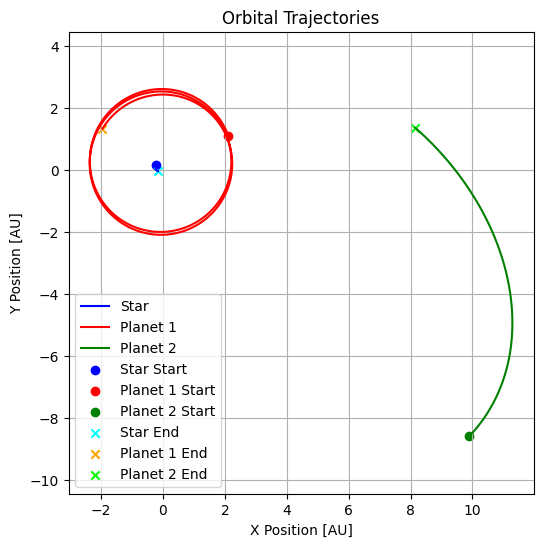

True Stable Prediction: Unstable
Random Forest Stable Prediction: Unstable


In [88]:
    # **Plot trajectories**
    plt.figure(figsize=(6, 6))
    plt.plot(star_x, star_y, 'b', label='Star')
    plt.plot(p1_x, p1_y, 'r', label='Planet 1')
    plt.plot(p2_x, p2_y, 'g', label='Planet 2')

    plt.scatter(star_x[0], star_y[0], color='blue', marker='o', label='Star Start')
    plt.scatter(p1_x[0], p1_y[0], color='red', marker='o', label='Planet 1 Start')
    plt.scatter(p2_x[0], p2_y[0], color='green', marker='o', label='Planet 2 Start')

    plt.scatter(star_x[-1], star_y[-1], color='cyan', marker='x', label='Star End')
    plt.scatter(p1_x[-1], p1_y[-1], color='orange', marker='x', label='Planet 1 End')
    plt.scatter(p2_x[-1], p2_y[-1], color='lime', marker='x', label='Planet 2 End')

    plt.xlabel("X Position [AU]")
    plt.ylabel("Y Position [AU]")
    plt.title("Orbital Trajectories")
    plt.legend()
    plt.grid()
    plt.axis('equal')

    plt.show()

    print("True Stable Prediction:", "stable" if y_test[test_sample_no] else "Unstable")
    print("Random Forest Stable Prediction:", "stable" if predict[test_sample_no] else "Unstable")